In [ ]:
import os
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from tensorflow import keras
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import auc, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount("/content/drive")

filepath = "drive/My Drive/ML/Hw2/"

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Mounted at /content/drive


In [ ]:
# plot ROC curve
def plot_roc(label, pred):
  fpr, tpr, _ = roc_curve(label, pred)
  roc_auc = auc(fpr, tpr)

  fig = plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.show()
  return

In [ ]:
# plot confusion matrix
def plot_confmat(label, pred):
  confmat = confusion_matrix(y_true=label, y_pred=pred)

  fig, ax = plt.subplots(figsize=(4,4))
  ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
  for i in range(confmat.shape[0]):
      for j in range(confmat.shape[1]):
          ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

  plt.xlabel('Predicted label')
  plt.ylabel('True label')

  plt.tight_layout()
  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(20)
  for item in (ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(15)
  plt.show()
  return

In [ ]:
def evaluate(label, pred, isFloat=False, plot=True):
  if isFloat == True:
    if plot == True:
      plot_roc(label, pred)
    pred = pred.round()
  if plot == True:
    # plot roc/confmat
    plot_roc(label, pred)
    plot_confmat(label, pred)
  # accuracy
  acc = accuracy_score(label, pred)
  print("Accuracy:", acc)
  # precision and recall
  precision = precision_score(label, pred)
  recall = recall_score(label, pred)
  print("Precision score:", precision)
  print("Recall score:", recall)
  print("P+R:", precision + recall)
  return

### Preprocess

In [ ]:
X = pd.read_csv(filepath + "hm_hospitales_covid_structured_30d_train.csv")
Y = pd.read_csv(filepath + "split_train_export_30d.csv")

,age,sex,vitals_temp_ed_first,vitals_sbp_ed_first,vitals_dbp_ed_first,vitals_hr_ed_first,vitals_spo2_ed_first,pmhx_diabetes,pmhx_hld,pmhx_htn,pmhx_ihd,pmhx_ckd,pmhx_copd,pmhx_asthma,pmhx_activecancer,pmhx_chronicliver,pmhx_stroke,pmhx_chf,pmhx_dementia,lab_aptt,lab_ldh,lab_sodium,lab_alt,lab_ddimer,lab_glucose,lab_potassium,lab_mch,lab_mean_platelet_volume,lab_inr,lab_hct,lab_creatinine,lab_ast,lab_crp,lab_mcv,lab_leukocyte,lab_lymphocyte_percentage,lab_prothrombin_activity,lab_urea,lab_rbc,lab_platelet,lab_neutrophil,lab_neutrophil_percentage,lab_lymphocyte,lab_rdw,lab_hemoglobin,sx_breathing_difficulty,sx_flu,sx_fever,sx_cough,sx_others
0,72,0,37.200000,111.000000,63.000000,94.000000,60.000000,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.300000,593.000000,135.00000,118.000000,908.000000,124.000000,4.340000,32.900000,11.20000,1.210000,36.000000,0.940000,45.000000,95.040000,96.300000,11.600000,5.000000,70.000000,67.000000,3.740000,238.000000,10.030000,86.500000,0.620000,13.000000,13.800000,1,0,0,0,0
1,50,1,37.200000,132.056604,76.333584,93.000000,94.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.400000,430.600000,138.20000,27.400000,234.000000,91.100000,4.570000,27.100000,10.00000,1.150000,39.800000,0.670000,25.800000,23.930000,82.400000,5.000000,28.000000,78.000000,26.400000,4.830000,197.000000,3.410000,68.200000,1.400000,13.900000,13.100000,1,0,0,0,0
2,78,1,36.400000,146.000000,96.000000,85.000000,96.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.023093,593.021408,137.24508,37.571113,2261.894511,124.681308,4.230853,29.736523,10.40381,1.412173,40.644879,1.019082,43.610835,97.821213,88.433288,7.661509,18.128456,74.892226,44.441714,4.608942,220.989892,5.725667,72.986649,1.237795,13.004062,13.659501,1,0,0,0,0
3,50,0,37.700000,132.056604,76.333584,124.000000,94.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,30.800000,694.400000,136.50000,66.600000,416.000000,96.200000,4.390000,27.600000,10.00000,1.240000,44.800000,0.880000,83.100000,71.260000,84.200000,6.160000,20.200000,69.000000,40.900000,5.320000,178.000000,4.600000,74.600000,1.180000,13.300000,14.700000,1,0,0,0,0
4,38,0,36.715113,132.056604,76.333584,89.506321,92.637438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.100000,790.100000,135.10000,62.700000,284.000000,105.200000,3.690000,30.000000,9.70000,1.110000,39.200000,0.770000,79.500000,128.420000,87.900000,7.020000,16.500000,89.000000,12.600000,4.460000,298.000000,4.920000,70.100000,1.160000,10.600000,13.400000,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829,53,0,36.900000,132.056604,76.333584,123.000000,93.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.023093,685.500000,132.80000,23.500000,2261.894511,393.100000,4.980000,29.700000,9.60000,1.120000,44.000000,0.630000,36.700000,243.190000,87.100000,7.690000,9.900000,86.000000,24.800000,5.050000,228.000000,6.580000,85.500000,0.760000,11.400000,15.000000,1,0,0,0,0
1830,91,0,36.900000,94.000000,51.000000,53.000000,95.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,33.023093,593.021408,137.24508,37.571113,2261.894511,124.681308,4.230853,29.736523,10.40381,1.412173,40.644879,1.019082,43.610835,97.821213,88.433288,7.661509,18.128456,74.892226,44.441714,4.608942,220.989892,5.725667,72.986649,1.237795,13.004062,13.659501,1,0,0,0,0
1831,87,1,36.000000,136.000000,68.000000,103.000000,89.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,33.023093,593.021408,137.24508,37.571113,2261.894511,124.681308,4.230853,29.736523,10.40381,1.412173,40.644879,1.019082,43.610835,97.821213,88.433288,7.661509,18.128456,74.892226,44.441714,4.608942,220.989892,5.725667,72.986649,1.237795,13.004062,13.659501,0,1,0,0,0
1832,39,1,36.300000,115.000000,74.000000,127.000000,97.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.700000,592.300000,140.30000,38.100000,3975.000

X shape: (1834, 50)
Y shape: (1834, 1)


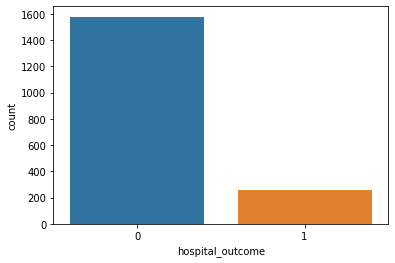

In [ ]:
# impute missing values
X = X.fillna(X.mean())

# check if there are any missing value
for c in X.columns:
  no_missing = X[c].isnull().sum()
  if no_missing > 0:
    print(c, no_missing)

# encode class input to one-hot
X['sex'] = X['sex'].map({'MALE': 0, 'FEMALE': 1})
ed_diagnosis_list = ['sx_breathing_difficulty', 'sx_flu', 'sx_fever', 'sx_cough', 'sx_others']
for element in ed_diagnosis_list:
  X[element] = X['ed_diagnosis'].map(lambda x: 1 if x == element else 0)

# drop useless information
X = X.drop(['PATIENT ID', 'admission_datetime', 'ed_diagnosis'], axis=1)
Y = Y.drop(['PATIENT ID'], axis=1)

display(X)
print("X shape:", X.shape)
print("Y shape:", Y.shape)
sns.countplot(Y['hospital_outcome'], label="Sum")
plt.show()

In [ ]:
# split training and testing data
X = np.asarray(X)
Y = np.asarray(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=0)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (1210, 50)
Y_train shape: (1210, 1)
X_test shape: (624, 50)
Y_test shape: (624, 1)


X_train shape: (2088, 50)
Y_train shape: (2088,)
X_test shape: (624, 50)
Y_test shape: (624, 1)


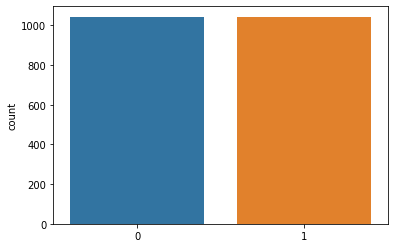

In [ ]:
# handle imbalanced data (oversampling)
smote = SMOTE(ratio='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)
sns.countplot(Y_train, label="Sum")

### Training

#### Dummy

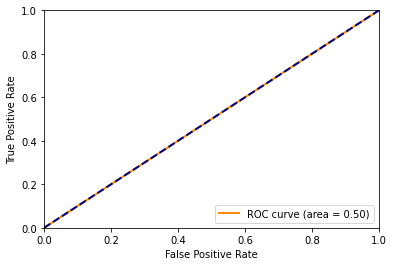

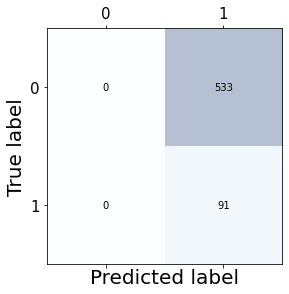

Accuracy: 0.14583333333333334
Precision score: 0.14583333333333334
Recall score: 1.0
P+R: 1.1458333333333333


In [ ]:
Y_pred = [1] * Y_test.shape[0]
evaluate(Y_test, Y_pred)

#### Logistic Regression

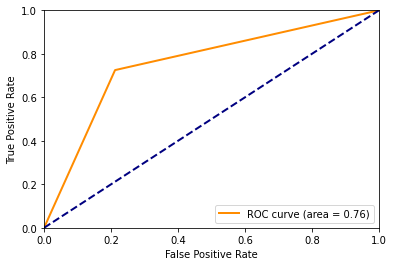

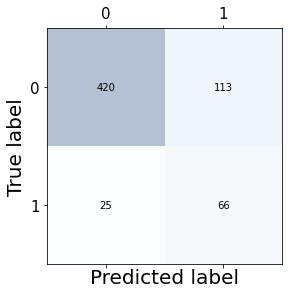

Accuracy: 0.7788461538461539
Precision score: 0.3687150837988827
Recall score: 0.7252747252747253
P+R: 1.093989809073608


In [ ]:
LR = LogisticRegression()
LR.fit(X_train, Y_train)

# make predictions
Y_pred = LR.predict(X_test)
evaluate(Y_test, Y_pred)

#### Naive Bayes

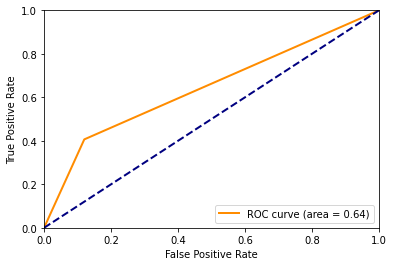

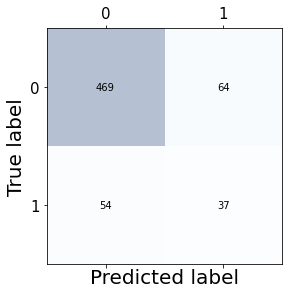

Accuracy: 0.8108974358974359
Precision score: 0.36633663366336633
Recall score: 0.4065934065934066
P+R: 0.7729300402567729


In [ ]:
bayes = GaussianNB()
bayes.fit(X_train, Y_train)

# make predictions
Y_pred = bayes.predict(X_test)
evaluate(Y_test, Y_pred)

#### KNN

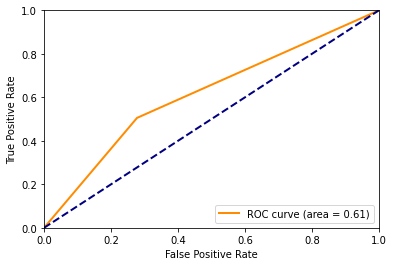

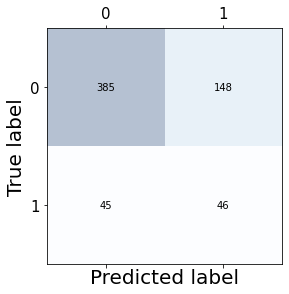

Accuracy: 0.6907051282051282
Precision score: 0.23711340206185566
Recall score: 0.5054945054945055
P+R: 0.7426079075563612


In [ ]:
KNN = KNeighborsClassifier()
KNN.fit(X_train, Y_train)

# make predictions
Y_pred = KNN.predict(X_test)
evaluate(Y_test, Y_pred)

#### SVC

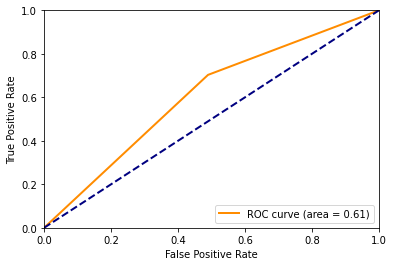

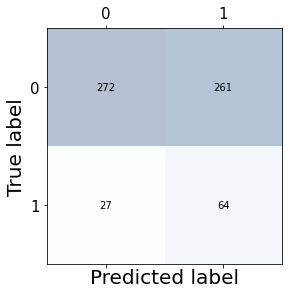

Accuracy: 0.5384615384615384
Precision score: 0.19692307692307692
Recall score: 0.7032967032967034
P+R: 0.9002197802197802


In [ ]:
SVM = SVC(probability = True)
SVM.fit(X_train, Y_train)

# make predictions
Y_pred = SVM.predict(X_test)
evaluate(Y_test, Y_pred)

#### Decision Tree

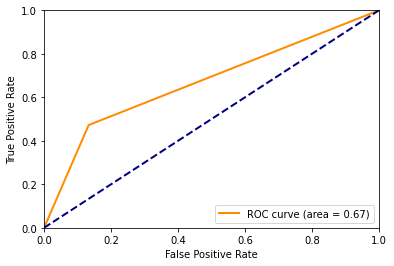

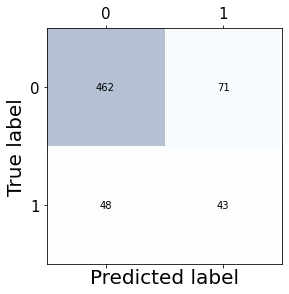

Accuracy: 0.8092948717948718
Precision score: 0.37719298245614036
Recall score: 0.4725274725274725
P+R: 0.8497204549836128


In [ ]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

# make predictions
Y_pred = decision_tree.predict(X_test)
evaluate(Y_test, Y_pred)

#### Random Forest

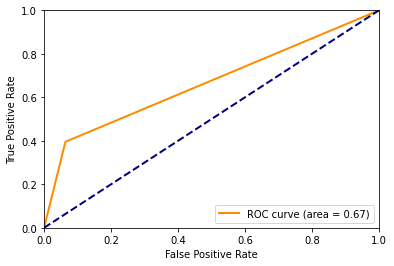

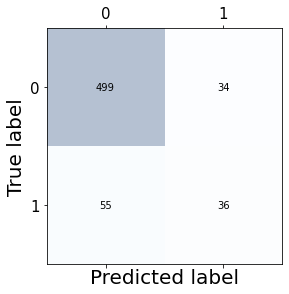

Accuracy: 0.8573717948717948
Precision score: 0.5142857142857142
Recall score: 0.3956043956043956
P+R: 0.9098901098901098


In [ ]:
forest = RandomForestClassifier()
forest.fit(X_train, Y_train)

# make predictions
Y_pred = forest.predict(X_test)
evaluate(Y_test, Y_pred)

#### XGBoost

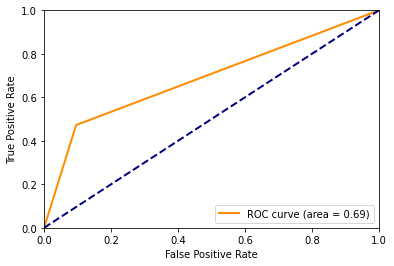

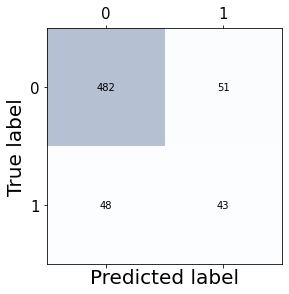

Accuracy: 0.8413461538461539
Precision score: 0.4574468085106383
Recall score: 0.4725274725274725
P+R: 0.9299742810381109


In [ ]:
xgbc = XGBClassifier()
xgbc.fit(X_train, Y_train)

# make predictions
Y_pred = xgbc.predict(X_test)
evaluate(Y_test, Y_pred)

#### Ensemble

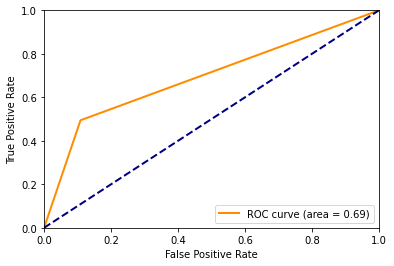

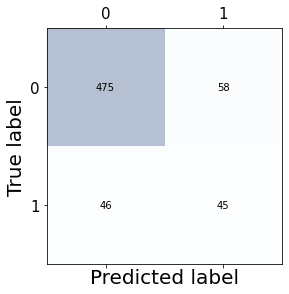

Accuracy: 0.8333333333333334
Precision score: 0.4368932038834951
Recall score: 0.4945054945054945
P+R: 0.9313986983889897


In [ ]:
models = [
  LogisticRegression(),
  GaussianNB(),
  KNeighborsClassifier(),
  SVC(probability = True),
  DecisionTreeClassifier(),
  RandomForestClassifier(),
  XGBClassifier()
]

models_ens = list(zip(['LR', 'NB', 'KNN', 'SVC', 'DT', 'RF', 'XGB'], models))
model_ens = VotingClassifier(estimators = models_ens, voting = 'soft')
model_ens.fit(X_train, Y_train)
Y_pred = model_ens.predict(X_test)
evaluate(Y_test, Y_pred)

#### Neural Network

In [ ]:
# build model
model = keras.models.Sequential([
    keras.layers.Flatten(input_dim=X.shape[1]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=1, activation='sigmoid')
])
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['AUC'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 50)                200       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1632      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 32)                128       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)               

In [ ]:
# train model
history = model.fit(X_train, Y_train, batch_size=256, epochs=40, validation_data=(X_test, Y_test))

Epoch 1/40
9/9 [==============================] - 0s 38ms/step - loss: 0.8610 - auc: 0.5265 - val_loss: 1.7030 - val_auc: 0.5000
Epoch 2/40
9/9 [==============================] - 0s 5ms/step - loss: 0.8227 - auc: 0.5564 - val_loss: 1.0095 - val_auc: 0.5228
Epoch 3/40
9/9 [==============================] - 0s 5ms/step - loss: 0.7932 - auc: 0.5668 - val_loss: 0.6805 - val_auc: 0.6413
Epoch 4/40
9/9 [==============================] - 0s 5ms/step - loss: 0.7562 - auc: 0.5844 - val_loss: 0.5210 - val_auc: 0.6760
Epoch 5/40
9/9 [==============================] - 0s 6ms/step - loss: 0.7368 - auc: 0.6128 - val_loss: 0.4404 - val_auc: 0.7116
Epoch 6/40
9/9 [==============================] - 0s 5ms/step - loss: 0.7089 - auc: 0.6351 - val_loss: 0.4018 - val_auc: 0.7259
Epoch 7/40
9/9 [==============================] - 0s 5ms/step - loss: 0.6828 - auc: 0.6498 - val_loss: 0.3813 - val_auc: 0.7356
Epoch 8/40
9/9 [==============================] - 0s 6ms/step - loss: 0.6804 - auc: 0.6515 - val_loss: 

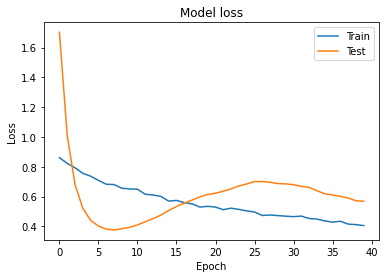

In [ ]:
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

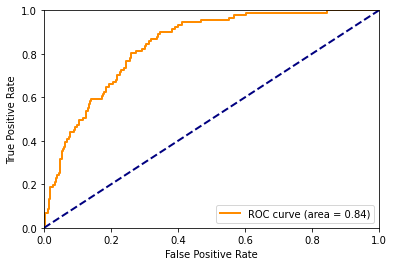

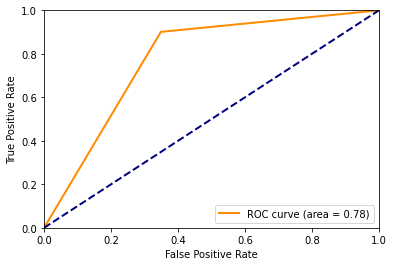

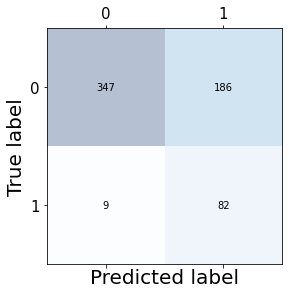

Accuracy: 0.6875
Precision score: 0.30597014925373134
Recall score: 0.9010989010989011
P+R: 1.2070690503526325


In [ ]:
# make predictions
Y_pred = model.predict(X_test)
evaluate(Y_test, Y_pred, isFloat=True)

In [ ]:
# make directory
if not os.path.exists(filepath + 'output'):
  os.makedirs(filepath + 'output')

# save model
model.save(filepath + "output/106062314_HW2_Model.h5")

### Testing

In [ ]:
testing_data = pd.read_csv(filepath + "fixed_test.csv")
patient_id = testing_data['PATIENT ID']

In [ ]:
# impute missing values
testing_data = testing_data.fillna(testing_data.mean())

# check if there are any missing value
for c in testing_data.columns:
  no_missing = testing_data[c].isnull().sum()
  if no_missing > 0:
    print(c, no_missing)

# encode class input to one-hot
testing_data['sex'] = testing_data['sex'].map({'MALE': 0, 'FEMALE': 1})
ed_diagnosis_list = ['sx_breathing_difficulty', 'sx_flu', 'sx_fever', 'sx_cough', 'sx_others']
for element in ed_diagnosis_list:
  testing_data[element] = testing_data['ed_diagnosis'].map(lambda x: 1 if x == element else 0)

# drop useless information
testing_data = testing_data.drop(['PATIENT ID', 'admission_datetime', 'ed_diagnosis'], axis=1)

In [ ]:
model_load = keras.models.load_model(filepath + "output/106062314_HW2_Model.h5")

# make predictions
Y_pred = model_load.predict(testing_data).round()
Y_pred = np.array(Y_pred)

# save predictions
df = pd.DataFrame(Y_pred)
df.columns = ['hospital_outcome']
df.index = patient_id
df.to_csv(filepath + "output/106062314_HW2.csv")